### EDA on DrivenData Box Plots for Education dataset

#### Agenda

* Targets
    * What are they?
    * For each target
        * Labels
            * how many of each?
            * distribution?

* Features
    * How many values per feature?
    * Types:
        * numerical
            * distribution
        * strings
            * how many distinct strings?  tokens
            * how many of each?
            * would preprocessing change those statistics
                * tokenization pattern
                * stemming


* Look at the holdout set.  From mismatch between train/test and submitted results, it seems that there must be some difference(s) from the labeled training data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# read the data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [4]:
# check shape
df.shape

(400277, 25)

In [5]:
# columns 0-8 are the targets; 9-25 are the features
df.columns

Index(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status',
       'Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'FTE', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Total',
       'Program_Description', 'Fund_Description', 'Text_1'],
      dtype='object')

In [6]:
# read the holdout set
holdout = pd.read_csv('data/TestData.csv', index_col=0)

C:\Users\saus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# check shape.  This has only features, no targets
holdout.shape

(50064, 16)

In [8]:
# since the holdout has no labels, these are the features.
sorted(list(holdout.columns))

['FTE',
 'Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4',
 'Total']

### Explore the targets (outputs to be predicted) and their distribution.

In [9]:
# bind a name for the targets
TARGETS = sorted(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
                'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'])

In [10]:
# check
print(TARGETS)

['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']


In [11]:
# and the features
FEATURES = sorted(list(set(df.columns) - set(TARGETS))); print(FEATURES)

['FTE', 'Facility_or_Department', 'Function_Description', 'Fund_Description', 'Job_Title_Description', 'Location_Description', 'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4', 'Total']


In [12]:
# only the text features
TFEATURES = ['Facility_or_Department', 'Function_Description', 'Fund_Description', 
             'Job_Title_Description', 'Location_Description', 'Object_Description', 
             'Position_Extra', 'Program_Description', 'SubFund_Description', 
             'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4']

In [13]:
# only the numerical features
NFEATURES = ['FTE', 'Total']

In [14]:
# any unlabeled rows in the dataset? No.
df[TARGETS].isnull().sum()

Function            0
Object_Type         0
Operating_Status    0
Position_Type       0
Pre_K               0
Reporting           0
Sharing             0
Student_Type        0
Use                 0
dtype: int64

In [15]:
# number of unique labels for each target
df[TARGETS].nunique()

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64

####  Look at the label counts for each target.  For the whole dataset, we could use value_counts, but we may need run this on arrays, so we use numpy. 

Since we may want to do this more than once, it's worth building some code to do it.  

We need to see label distributions for all the targets.   

#### Build the the label counts input for the plotter.

In [16]:
def build_label_counts(target_array):
    ''' takes array of targets and builds mapping: target to dataframe.
        dataframe contains 2 columns: labels and counts of labels, sorted by label count    '''
    # first build dict to hold count of labels, keyed by target
    label_counts = {t : np.unique(df[t], return_counts=True) for t in TARGETS}
    # sort by counts and push into df, retaining dictionary structure.
    return {t : pd.DataFrame(sorted(list(zip(label_counts[t][0], label_counts[t][1])), 
                                    key=lambda x: x[1])) for t in TARGETS}

#### Build the plotter.

In [17]:
def plot_label_profile(targets, size=15):
    ''' draw the picture using the input from build_label_counts'''
    fig, axes = plt.subplots(3, 3, figsize=(size,size))
    for n, t in enumerate(targets.keys()):
        the_ax = axes[n//3][n%3]
        the_ax.set_title(t)
        the_ax.bar(targets[t].index, targets[t].iloc[:, 1]);

In [18]:
def show_label_profile(target_array, size=15):
    plot_label_profile(build_label_counts(target_array), size=size)

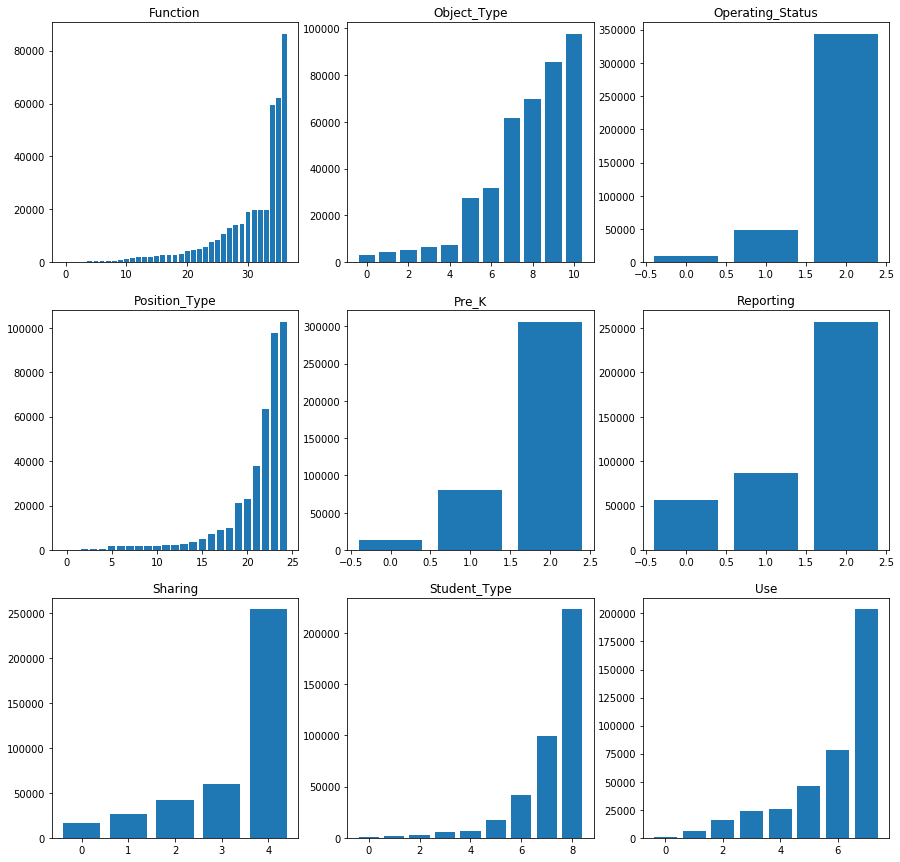

In [19]:
show_label_profile(df[TARGETS], size=15)

#### The plot shows significant label imbalance for most targets.

#### ================================================================================

## Explore the features

In [20]:
# how about empty features; lots and lots.
df[FEATURES].isnull().sum()

FTE                       274206
Facility_or_Department    346391
Function_Description       58082
Fund_Description          197400
Job_Title_Description     107534
Location_Description      238223
Object_Description         24784
Position_Extra            135513
Program_Description        95617
SubFund_Description        93422
Sub_Object_Description    308674
Text_1                    107992
Text_2                    312060
Text_3                    291125
Text_4                    346531
Total                       4555
dtype: int64

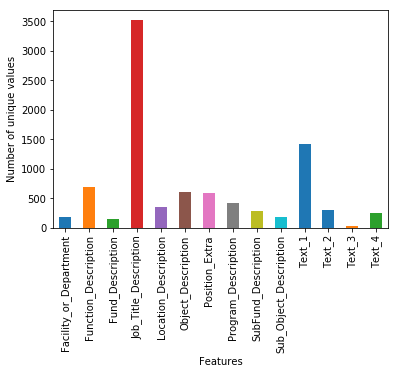

In [21]:
# Calculate number of unique values for each text feature: num_unique_values
num_unique_values = df[TFEATURES].apply(pd.Series.nunique, axis=0)

# Plot number of unique values for each label
num_unique_values.plot(kind='bar')

# Label the axes
plt.xlabel('Features')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

#### Are holdout and test data (really train and test together)  different?

I can't compare the labels because they are withheld for the holdout set.  So the plots below look at the features, to see if there's a difference.  

We count the number of unique entries in the features and divide by number of samples.  Shapes are similar, numbers off by 1/2 to 1 order of magnitude.  Since the dataset is 10 times as big as the holdout, that tells me there are relatively more different unique values in the holdout.

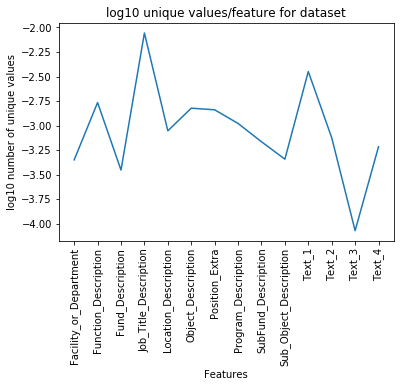

In [22]:
# FEATURES = ['Facility_or_Department', 'Function_Description',  'Fund_Description', 'Job_Title_Description', 
#             'Location_Description','Object_Description','Position_Extra',  'Program_Description', 'SubFund_Description',
#             'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
#
plt.plot(np.log10(df[TFEATURES].nunique()/df.shape[0]))
plt.xticks(TFEATURES, rotation=90)
plt.xlabel('Features')
plt.ylabel('log10 number of unique values')
plt.title('log10 unique values/feature for dataset');

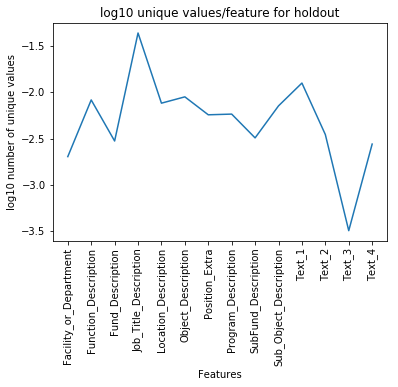

In [23]:
plt.plot(np.log10(holdout[TFEATURES].nunique()/holdout.shape[0]))
plt.xticks(TFEATURES, rotation=90)
plt.xlabel('Features')
plt.ylabel('log10 number of unique values')
plt.title('log10 unique values/feature for holdout');

## Look at the number of tokens in the features.

#### Build a function to get the token set (combining all text fields in a row) using default CountVectorizer.

In [24]:
def get_token_pop(data, feature_names):
    ''' Input is columns of text data; 
        Output is tuple: mapping: feature_name to list of tokens; list of unique tokens in entire input.'''
    tokens_by_feature = {f : CountVectorizer().fit(data[f].fillna('')).get_feature_names()
                           for f in feature_names}
    t_numbers = []
    all_tokens = []                    
    for f in feature_names:
        t_numbers.append(len(tokens_by_feature[f]))
        all_tokens.extend(tokens_by_feature[f])
        print('Feature: {} has {} tokens'.format(f, len(tokens_by_feature[f])))
    all_tokens = list(set(all_tokens))
    print('total number of tokens for all features: {}'.format(np.sum(t_numbers)))  
    print('total number of unique tokens for all features: {}'.format(len(set(all_tokens)))) 
    return (tokens_by_feature, all_tokens)

#### Get the token population and count tokens by feature and total unique tokens for full dataset and the holdout set.

In [25]:
# get token dictionary and unique tokens for full dataset
df_token_dict, df_all_tokens = get_token_pop(df[TFEATURES],TFEATURES)

Feature: Facility_or_Department has 251 tokens
Feature: Function_Description has 802 tokens
Feature: Fund_Description has 225 tokens
Feature: Job_Title_Description has 1642 tokens
Feature: Location_Description has 414 tokens
Feature: Object_Description has 578 tokens
Feature: Position_Extra has 497 tokens
Feature: Program_Description has 528 tokens
Feature: SubFund_Description has 397 tokens
Feature: Sub_Object_Description has 275 tokens
Feature: Text_1 has 1571 tokens
Feature: Text_2 has 356 tokens
Feature: Text_3 has 66 tokens
Feature: Text_4 has 370 tokens
total number of tokens for all features: 7972
total number of unique tokens for all features: 3728


In [26]:
# get token dictionary and unique tokens for full dataset
ho_token_dict, ho_all_tokens = get_token_pop(holdout[TFEATURES],TFEATURES)

Feature: Facility_or_Department has 153 tokens
Feature: Function_Description has 525 tokens
Feature: Fund_Description has 246 tokens
Feature: Job_Title_Description has 1328 tokens
Feature: Location_Description has 409 tokens
Feature: Object_Description has 433 tokens
Feature: Position_Extra has 328 tokens
Feature: Program_Description has 381 tokens
Feature: SubFund_Description has 263 tokens
Feature: Sub_Object_Description has 519 tokens
Feature: Text_1 has 850 tokens
Feature: Text_2 has 259 tokens
Feature: Text_3 has 26 tokens
Feature: Text_4 has 218 tokens
total number of tokens for all features: 5938
total number of unique tokens for all features: 2766


#### Build function to compare token lists; should take two lists and return 3-tuple: list of items in both sets, list of items only in 1st input, list of items only in 2nd input.

In [27]:
def compare_token_lists(l1, l2):
    s1, s2 = set(l1), set(l2)
    inboth = sorted(list(s1 & s2))
    inl1 = sorted(list(s1 - s2))
    inl2 = sorted(list(s2 - s1))
    return (inboth, inl1, inl2)

In [28]:
inboth, inl1, inl2 = compare_token_lists(df_all_tokens, ho_all_tokens)

In [29]:
len(inboth), len(inl1), len(inl2)

(2411, 1317, 355)

#####     holdout has 2766 unique tokens.  2411 were seen in dataset; 355 tokens not seen in the dataset.

In [30]:
print(inl2)

['7th', '8th', 'aas', 'abate', 'abc', 'abd', 'abuse', 'accntab', 'accounta', 'acctg', 'accts', 'actbly', 'adapt', 'administr', 'administratvie', 'advisory', 'aep', 'aff', 'african', 'agricul', 'ah', 'ahc', 'al', 'alarms', 'algebra', 'alterations', 'analy', 'analyiii', 'anly', 'ann', 'anst', 'anticipation', 'appreciation', 'appren', 'ar', 'architectur', 'arrangements', 'as', 'asbes', 'asperger', 'assessmen', 'association', 'ast', 'astii', 'attend', 'au', 'aud', 'baccalaureate', 'badges', 'baptist', 'baseb', 'basebl', 'bb', 'beh', 'between', 'blue', 'bnfts', 'braillist', 'bsktbl', 'build', 'busn', 'cafm', 'campuses', 'capitol', 'carr', 'carry', 'cataloging', 'cate', 'cch', 'cdr', 'cell', 'chf', 'chi', 'chld', 'civ', 'cl', 'clas', 'cler', 'clinicans', 'cntl', 'coga', 'combin', 'commercial', 'commun', 'comptroller', 'cond', 'config', 'construct', 'consulting', 'cor', 'cord', 'cosme', 'coun', 'courier', 'cpl', 'cred', 'credits', 'ctrl', 'cultural', 'cur', 'cycle', 'dba', 'de', 'demonstratio

#####  Next question: Which feature(s) are the unseen tokens in?

In [31]:
# compare tokenizing only within features
for f in TFEATURES:
    inboth, inl1, inl2 = compare_token_lists(df_token_dict[f], ho_token_dict[f])
    print('feature {}, in both: {}, in 1 only: {}, in 2 only: {}'.format(f, len(inboth), len(inl1), len(inl2)))

feature Facility_or_Department, in both: 152, in 1 only: 99, in 2 only: 1
feature Function_Description, in both: 511, in 1 only: 291, in 2 only: 14
feature Fund_Description, in both: 186, in 1 only: 39, in 2 only: 60
feature Job_Title_Description, in both: 1008, in 1 only: 634, in 2 only: 320
feature Location_Description, in both: 317, in 1 only: 97, in 2 only: 92
feature Object_Description, in both: 392, in 1 only: 186, in 2 only: 41
feature Position_Extra, in both: 327, in 1 only: 170, in 2 only: 1
feature Program_Description, in both: 373, in 1 only: 155, in 2 only: 8
feature SubFund_Description, in both: 263, in 1 only: 134, in 2 only: 0
feature Sub_Object_Description, in both: 227, in 1 only: 48, in 2 only: 292
feature Text_1, in both: 846, in 1 only: 725, in 2 only: 4
feature Text_2, in both: 257, in 1 only: 99, in 2 only: 2
feature Text_3, in both: 26, in 1 only: 40, in 2 only: 0
feature Text_4, in both: 216, in 1 only: 154, in 2 only: 2


##### So there is perhaps some value in using the token set for all fields to represent the features, because if you tokenize within a feature, you'll miss words that might be used in new data that could have been captured. I'm not sure if that's going to help in classification or not.

In [32]:
# now the same question, but see if the unseen tokens in holdout are seen in the collection of tokens from the dataset
for f in TFEATURES:
    inboth, inl1, inl2 = compare_token_lists(df_all_tokens, ho_token_dict[f])
    print('feature {}, in both: {}, in 1 only: {}, in 2 only: {}'.format(f, len(inboth), len(inl1), len(inl2)))

feature Facility_or_Department, in both: 153, in 1 only: 3575, in 2 only: 0
feature Function_Description, in both: 518, in 1 only: 3210, in 2 only: 7
feature Fund_Description, in both: 235, in 1 only: 3493, in 2 only: 11
feature Job_Title_Description, in both: 1087, in 1 only: 2641, in 2 only: 241
feature Location_Description, in both: 390, in 1 only: 3338, in 2 only: 19
feature Object_Description, in both: 417, in 1 only: 3311, in 2 only: 16
feature Position_Extra, in both: 328, in 1 only: 3400, in 2 only: 0
feature Program_Description, in both: 375, in 1 only: 3353, in 2 only: 6
feature SubFund_Description, in both: 263, in 1 only: 3465, in 2 only: 0
feature Sub_Object_Description, in both: 454, in 1 only: 3274, in 2 only: 65
feature Text_1, in both: 846, in 1 only: 2882, in 2 only: 4
feature Text_2, in both: 258, in 1 only: 3470, in 2 only: 1
feature Text_3, in both: 26, in 1 only: 3702, in 2 only: 0
feature Text_4, in both: 216, in 1 only: 3512, in 2 only: 2


#### A quick look at the features with the most new tokens in the holdout set.

In [33]:
# unique strings in Sub_Obj_Desc...
len(holdout.Sub_Object_Description.dropna().unique())

357

In [34]:
# how many non-null/null in Job_Title_Desc
holdout.Job_Title_Description.notnull().sum(), holdout.Job_Title_Description.isnull().sum()

(32317, 17747)

In [35]:
# unique strings in Job_Title_Desc
len(holdout.Job_Title_Description.dropna().unique())

2190

### Look at the numerical features.

#### FTE

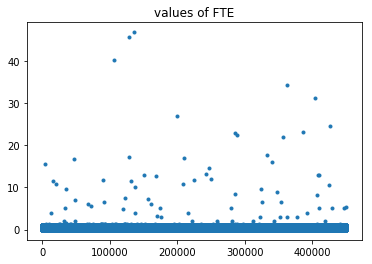

In [36]:
df.FTE.plot(marker='.', linestyle='none')
plt.title('values of FTE');

In [37]:
df.FTE.isnull().sum()

274206

In [38]:
df.FTE.describe()

count    126071.000000
mean          0.426794
std           0.573576
min          -0.087551
25%           0.000792
50%           0.130927
75%           1.000000
max          46.800000
Name: FTE, dtype: float64

Text(0.5,1,'distribution of log10 FTE')

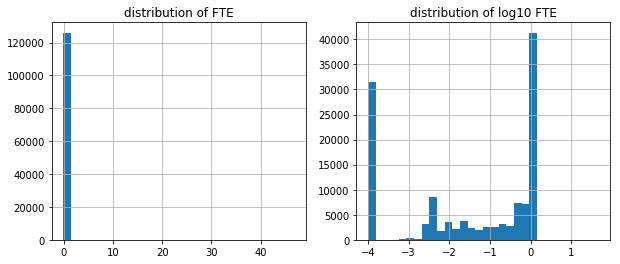

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df.FTE.hist(ax=ax1, bins=30)
ax1.set_title('distribution of FTE')
# have to do something about zero values, negative values, and very small values
np.log10(df.FTE.transform(lambda x: 10e-5 if (x <= 10e-5) else x)).hist(ax=ax2, bins=30)
ax2.set_title('distribution of log10 FTE')

#### This feature has 274k  NaNs, and some bogus entries (< 0 or very, very small).  But if you get rid of those, it may be possible to usefully bin the values by the log (or  a fraction).

#### Total

It looks like the negative numbers are just someone's convention that doesn't make sense since all of these line items represent spending.  Very well may be possible to use the absolute value of the feature.

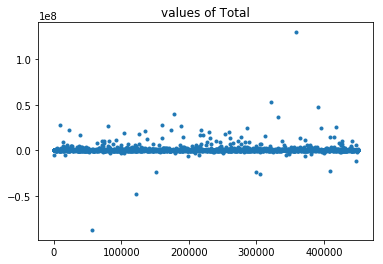

In [40]:
df.Total.plot(marker='.', linestyle='none')
plt.title('values of Total');

In [41]:
# how many nulls
df.Total.isnull().sum()

4555

In [42]:
# how many greater/less than 0; about 10% are negative
(df.Total > 0).sum(), (df.Total < 0).sum()

(351806, 43870)

#### Summary stats 

In [43]:
df.Total.describe()

count    3.957220e+05
mean     1.310586e+04
std      3.682254e+05
min     -8.746631e+07
25%      7.379770e+01
50%      4.612300e+02
75%      3.652662e+03
max      1.297000e+08
Name: Total, dtype: float64

In [44]:
np.absolute(df.Total).describe()

count    3.957220e+05
mean     1.706067e+04
std      3.680634e+05
min      0.000000e+00
25%      1.290962e+02
50%      6.531659e+02
75%      4.571945e+03
max      1.297000e+08
Name: Total, dtype: float64

#### The max is a strange value; let's examine the row.

In [45]:
df[df.Total > 1e8]

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
358538,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,"Operating, Not PreK-12",Payments to a Community School*,NaN,Regular Instruction,NaN,NaN,NaN,Tuition And Other Similar Payments,NaN,NaN,Other Regular,NaN,NaN,1.297000e+08,NaN,General,SPECIAL PROJECTS-FINANCIA


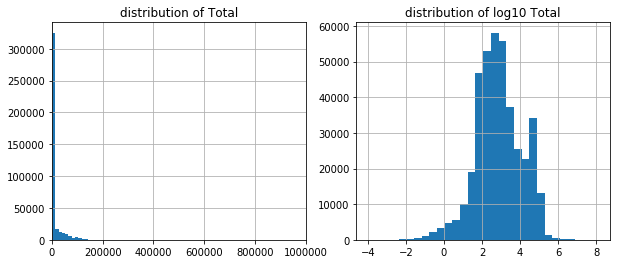

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

np.abs(df.Total.dropna()).hist(ax=ax1, bins=10000)
ax1.set_title('distribution of Total')
ax1.set_xlim(0, 1e6)
# have to do something about zero values, negative values, and very small values
np.log10(np.abs(df.Total).transform(lambda x: 10e-5 if (x <= 10e-5) else x)).hist(ax=ax2, bins=30)
ax2.set_title('distribution of log10 Total');

#### The standard histogram is rendered pretty much useless by the extreme values at the high end.  The log version tells us that without the outliers we have a fairly well-behaved set of values.  Again, binning may be useful.

In [47]:
### look at some rows where total is negative
df[df.Total < 0].sample(n=5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
396891,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,NaN,Other Instruction,NaN,NaN,NaN,Certificated Employees Salaries And Wages,NaN,NaN,Summer Remediation *,NaN,NaN,-905.64,NaN,Title I - Disadvantaged Children/Targeted Assi...,SCHOOLWIDE-AAPS
17,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Classroom Supplies,NaN,Support Services--Pupils,NaN,NaN,NaN,General Supplies *,NaN,NaN,Direction of Support Services - Pupils *,NaN,NaN,-421.05,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I SCHOOLWIDE
301679,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Benefits,NO_LABEL,PreK-12 Operating,CONTRA BENEFITS,NaN,GENERAL FUND,"Teacher, Summer School",NaN,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,UNDESIGNATED,-24.21,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
179871,Substitute Compensation,Instruction,School Reported,School,Unspecified,Other,Benefits,NO_LABEL,PreK-12 Operating,CONTRA BENEFITS,NaN,GENERAL FUND,Tutor Interpreter,NaN,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,UNDESIGNATED,-147.00,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
443061,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Contracted Food Services,NaN,Community Services,NaN,NaN,NaN,Contracted Craft Or Trade Services *,NaN,NaN,Other Community Services *,NaN,NaN,-718.47,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I C/O-ENCUMBR


## Look at the token set.  See if stemming can help.

The are many abbreviations and typos/misspellings.

In [48]:
# sort the token set
corpus = sorted(df_all_tokens)

In [49]:
import nltk
from nltk.corpus import stopwords, LazyCorpusLoader

english_stops = stopwords.words('english')

In [50]:
len(corpus)

3728

In [51]:
no_stops = [t for t in corpus if t not in english_stops]

#### Got rid of ~50 tokens

In [52]:
len(no_stops)

3680

In [53]:
from nltk.stem import WordNetLemmatizer
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [54]:
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

In [55]:
len(lemmatized)

3680

#### not at all

In [56]:
from nltk.stem.porter import PorterStemmer

In [57]:
pstem = PorterStemmer()
porterized = [pstem.stem(t) for t in corpus]

In [58]:
len(porterized)

3728

### Stemming is not going to gain us much if anything without more work.  A more fruitful approach would be something like (but not exactly) spelling correction.

E.g. 'adm', 'admin', 'adminis', 'administ', 'administrat', 'administration', 'administrative', 'administrator', 'administrators'
probably all mean the same thing.  Collapse multiple tokens onto 1 and results should improve.

#### For reference, all the tokens from the dataset are below.

In [59]:
print(corpus)

['00a', '12', '1st', '2nd', '3rd', '4th', '56', '5th', '60', '60hrs', '6th', '70', '70h', '70hr', '70hrs', '70hs', '720', '80', '80hrs', '80hs', '84', '9th', 'aaps', 'ab', 'aba', 'abatement', 'absence', 'absorber', 'ac', 'acad', 'academ', 'academic', 'academically', 'academies', 'academy', 'acadmey', 'acc', 'accelerated', 'access', 'accessories', 'accident', 'accnts', 'accompanists', 'accoun', 'account', 'accountability', 'accountant', 'accountants', 'accounting', 'accounts', 'acct', 'acctblty', 'achiev', 'achieve', 'achievment', 'achv', 'acq', 'acqu', 'acquis', 'acquisition', 'acquisitions', 'act', 'acte', 'acti', 'acting', 'action', 'active', 'activi', 'activiti', 'activities', 'activity', 'activties', 'actually', 'actuary', 'ad', 'ada', 'adapted', 'adaptive', 'add', 'addit', 'addition', 'additional', 'addl', 'addtn', 'adie', 'aditional', 'adj', 'adjustme', 'adjustment', 'adjustments', 'adl', 'adm', 'admin', 'adminis', 'administ', 'administrat', 'administration', 'administrative', 'a